In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
from matplotlib import cm
from matplotlib.ticker import LinearLocator

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

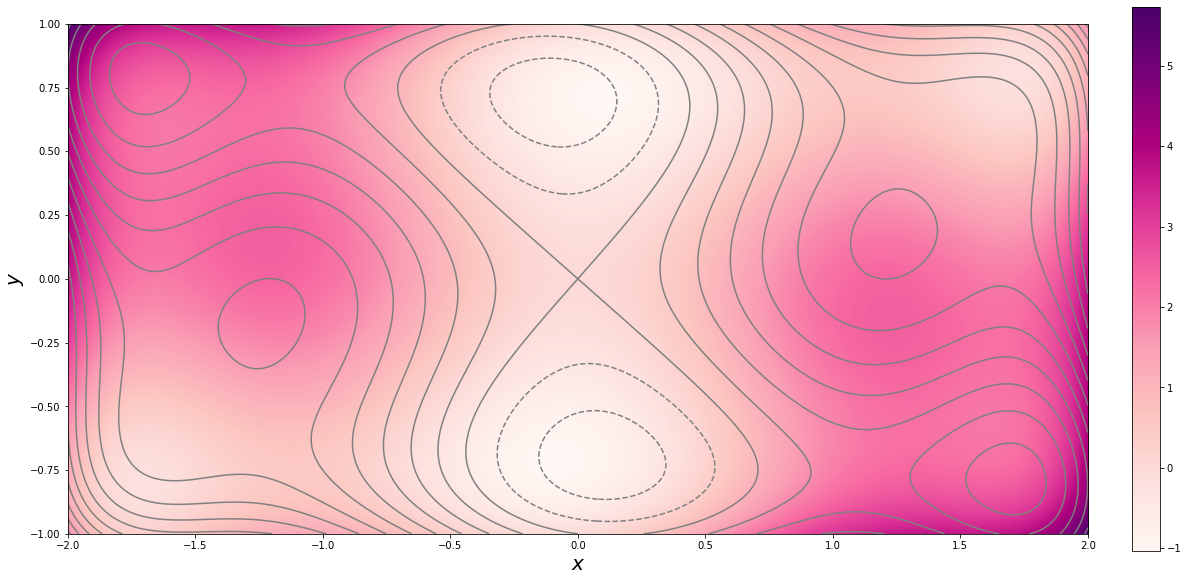

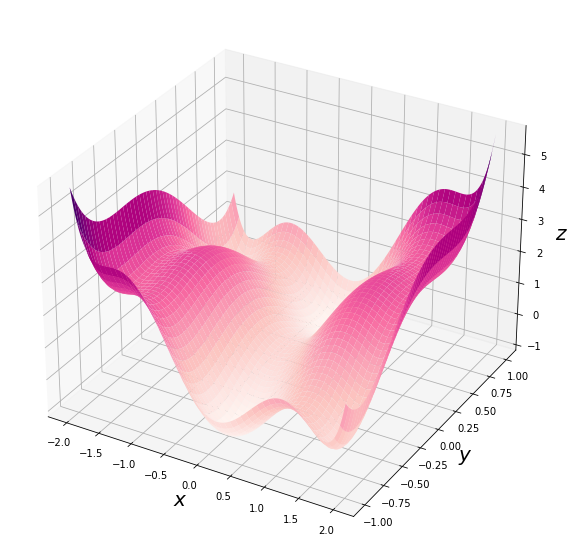

In [114]:
def f(x):
    y = x[1]
    x = x[0]
    f = (4 - 2.1 * x**2 + x**4 / 3) * x**2 + x*y + (4*y**2-4)*y**2
    return f

x = np.linspace(-2, 2, 1000)
y = np.linspace(-1, 1, 1000)

X, Y = np.meshgrid(x, y)
Z = f([X, Y])

plt.figure(figsize=(20, 10))
img = plt.imshow(Z, cmap = "RdPu",extent=[-2, 2, -1, 1])
plt.contour(X, Y, Z, levels = 20, colors = "grey")
plt.colorbar(img, fraction=0.046, pad=0.04)
plt.xlabel("$x$", fontsize = 20)
plt.ylabel("$y$", fontsize = 20)
plt.show()


# Plot the surface.
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap = "RdPu", linewidth=0, antialiased=True)
ax.set_xlabel("$x$", fontsize = 20)
ax.set_ylabel("$y$", fontsize = 20)
ax.set_zlabel("$z$", fontsize = 20)
plt.show()

By checking the previous plots, we can visually get a first estimate of the minima of the function. We can therefore try now to use scipy functions to find accurately these minima from our estimates.

In [164]:
x0 = [[0.1, -0.75], [-0.1, 0.75], [-1.75, -0.6], [-1.75, 0.8], [1.75, 0.75], [1.75, -0.8]]

minima = []
f_min = []
f_gl_min = 2

for estimate in x0:
    minimum = so.minimize(f, estimate, method = "Nelder-Mead")
    if minimum.success:
        minima.append(minimum.x)
        f_min.append(f(minimum.x))
        if f(minimum.x) <= f_gl_min: # appending the first global minimum and getting the function value
            f_gl_min = f(minimum.x)
            gl_min = minimum.x

# checking the second global minimum
for m in minima:
    if np.isclose(f(m), f_gl_min) and any(m != gl_min):
        gl_min2 = m
        f_gl_min2 = f(m)


print(gl_min, gl_min2)

[-0.08982456  0.71268148] [ 0.08982456 -0.71268148]


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.